In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import MSTL, HoltWinters
from tqdm.autonotebook import tqdm

# this makes it so that the outputs of the predict methods have the id as a column 
# instead of as the index
os.environ['NIXTLA_ID_AS_COL'] = '1'

# = = = = = =
# own stuff
# = = = = = =
os.chdir('../')
import data_prepro as data_prepro  # noqa: E402
import model_train as model_train # noqa: E402
import model_fcast as model_fcast # noqa: E402
import model_eval as model_eval # noqa: E402

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# >>> generate prediction timestamps based on t0 = following thursday 00:00 dynamically
# = = = = = = = = = = = = = 

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
t_now = '2024-01-24'
t_now = pd.Timestamp(t_now, tz='CET')

# get thursday and wednesday
days_left = 3 - t_now.weekday() # get days left till thursday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
t_sunday = t_thursday + pd.Timedelta(days=3)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")
print(f"sun = {t_sunday}")

# t_monday_next = t_thursday + pd.Timedelta(days=4)
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
# print(f"next mon = {t_monday_next}")
print(f"next wed = {t_wednesday_next}")

# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)))
print(subm_timestamps)

wed = 2024-01-24 00:00:00+01:00
thu = 2024-01-25 00:00:00+01:00
sun = 2024-01-28 00:00:00+01:00
next wed = 2024-01-31 00:00:00+01:00
[Timestamp('2024-01-26 12:00:00+0100', tz='CET'), Timestamp('2024-01-26 16:00:00+0100', tz='CET'), Timestamp('2024-01-26 20:00:00+0100', tz='CET'), Timestamp('2024-01-27 12:00:00+0100', tz='CET'), Timestamp('2024-01-27 16:00:00+0100', tz='CET'), Timestamp('2024-01-27 20:00:00+0100', tz='CET')]


## Test

### statsmodels & sktime MSTL (BAD)

In [3]:
# mstl = MSTL(df_energy_small['gesamt'], periods=[24, 24*7], iterate=1, 
#             stl_kwargs={"seasonal_deg": 0,
#                         "inner_iter": 2,
#                         "outer_iter": 0})

# res = mstl.fit()

# plt.rc("figure", figsize=(15, 10))
# res.plot()
# plt.tight_layout()
# plt.show()

In [4]:
# # from sktime.datasets import load_airline
# from sktime.forecasting.statsforecast import StatsForecastMSTL

# y = df_energy_small['gesamt']
# model = StatsForecastMSTL(season_length=[24, 24*7], pred_int_kwargs={'n_windows':2, 'h':12})
# fitted_model = model.fit(y=y) 

In [5]:
# y_pred = fitted_model.predict(fh=np.arange(1,69)) 

# plt.figure(figsize=(15, 5))
# plt.plot(y_pred)
# plt.show()

In [6]:
# y_pred = fitted_model.predict_interval(fh=np.arange(1,69), coverage=0.95) 

# plt.figure(figsize=(15, 5))
# plt.plot(y_pred)
# plt.show()

### Statsforecast MSTL

In [7]:
# from statsforecast import StatsForecast
# from statsforecast.models import MSTL, HoltWinters
# from tqdm.autonotebook import tqdm

# # this makes it so that the outputs of the predict methods have the id as a column 
# # instead of as the index
# os.environ['NIXTLA_ID_AS_COL'] = '1'

In [8]:
# # = = = = = = = = = = = = = 
# # get true data
# df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take smaller train dataset
# start   = '2022-01-01'
# end     = df_energy['timestamp_CET'].max()
# end     = t_thursday.strftime('%Y-%m-%d')
# df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
#                                 (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"take smaller dataset ... from {start} to {end}")
# print(df_energy_small.info())

# # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# # take the required week 
# start   = t_thursday.strftime('%Y-%m-%d')
# end     = t_sunday.strftime('%Y-%m-%d')
# df_energy_true = df_energy.loc[(df_energy['timestamp_CET'] >= start) &
#                                (df_energy['timestamp_CET'] <= end)]

# print('- '*15)
# print(f"true data ... from {start} to {end}")
# print(df_energy_true.info())

### MSTL

In [9]:
# from importlib import reload
# reload(data_prepro)
# reload(model_train)
# reload(model_fcast)
# reload(model_eval)

In [10]:
# # StatsForecast needs this format
# df = df_energy_small.copy().rename(columns={'timestamp_CET': 'ds', 'gesamt': 'y'})
# df['unique_id'] = 'energy'

# # Use past 2 years data for MSTL ... take last 365 * 24 values
# df_mstl = df_energy_small.iloc[-2*365*24:].copy()
# # Use past 4 weeks data for HoltWinters
# df_hw = df_energy_small.iloc[-4*7*24:].copy()

In [11]:
# # MSTL's usage example
# mstl_model = MSTL(season_length=[24, 24*7])
# mstl_model = mstl_model.fit(df_mstl['gesamt'])

In [12]:
# # calculate how many step aheads in hours to last submission timestamp
# # to get the required number of hourly predictions
# n_steps = int((subm_timestamps[-1] - df['ds'].max()) / pd.Timedelta(hours=1)) + 5

# y_hat_dict = mstl_model.predict(h=n_steps, level=[50, 95])
# # y_hat_dict
# # turn the dictionary into a dataframe
# y_hat_df = pd.DataFrame(y_hat_dict)

# # add timestamp_CET column
# y_hat_df['timestamp_CET'] = pd.date_range(start=df['ds'].max(), periods=len(y_hat_df), freq='H')
# y_hat_df

# # rename columns
# y_hat_df = y_hat_df.rename(columns={'mean': 'q 0.500', 
#                                     'lo-50': 'q 0.250', 
#                                     'hi-50': 'q 0.750', 
#                                     'lo-95': 'q 0.025', 
#                                     'hi-95': 'q 0.975'})
# y_hat_df = y_hat_df[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, y_true=df_energy_true, title='MSTL fcast')

In [13]:
# model_eval.eval_fcast(y_hat_df, df_energy_true, subm_timestamps, quantiles)

### Holt Winters

In [14]:
# # Holt-Winters' usage example
# holt_winters_model = HoltWinters(season_length=24, error_type='A')
# holt_winters_model = holt_winters_model.fit(y=df_hw['gesamt'].values)

# # = = = = = = = = = = = = = = = = = = = = = = = = = #
# # !!! can only use 1 single seasonality parameter !!!
# # = = = = = = = = = = = = = = = = = = = = = = = = = #

In [15]:
# # calculate how many step aheads in hours to last submission timestamp
# # to get the required number of hourly predictions
# n_steps = int((subm_timestamps[-1] - df['ds'].max()) / pd.Timedelta(hours=1)) + 5

# y_hat_dict = holt_winters_model.predict(h=n_steps, level=[50, 95])
# # y_hat_dict
# # turn the dictionary into a dataframe
# y_hat_df = pd.DataFrame(y_hat_dict)

# # add timestamp_CET column
# y_hat_df['timestamp_CET'] = pd.date_range(start=df['ds'].max(), periods=len(y_hat_df), freq='H')
# y_hat_df

# # rename columns
# y_hat_df = y_hat_df.rename(columns={'mean': 'q 0.500', 
#                                     'lo-50': 'q 0.250', 
#                                     'hi-50': 'q 0.750', 
#                                     'lo-95': 'q 0.025', 
#                                     'hi-95': 'q 0.975'})
# y_hat_df = y_hat_df[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, y_true=df_energy_true, title='Holt Winters fcast')

In [16]:
# model_eval.eval_fcast(y_hat_df, df_energy_true, subm_timestamps, quantiles)

## Rolling Fcast Eval

In [17]:
from importlib import reload
reload(data_prepro)
reload(model_train)
reload(model_fcast)
reload(model_eval)

<module 'model_eval' from 'c:\\2023_11-PTSFC\\model_eval.py'>

In [18]:
# = = = = = = = = = = = = = 
# get all data
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
df_energy = data_prepro.get_energy_data_today(to_date=t_now.strftime('%Y%m%d'))

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller train dataset
start   = '2020-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]

print('- '*15)
print(f"take smaller dataset ... from {start} to {end}")
print(df_energy_small.info())

> cwd = c:\2023_11-PTSFC


> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


> 0 NA in df
> last valid index = 2024-01-31 20:00:00+00:00
> done and saved to 2015-01-01_2024-01-31_energy.csv
- - - - - - - - - - - - - - - 
take smaller dataset ... from 2020-01-01 to 2024-01-31 21:00:00+01:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35805 entries, 2020-01-01 00:00:00+00:00 to 2024-01-31 20:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  35805 non-null  datetime64[ns, CET]
 1   gesamt         35805 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 839.2 KB
None


In [70]:
n_fold = 1

# get past n_fold + 1 wednesdays
t_wednesday = t_now - pd.Timedelta(days=2-t_now.weekday())
past_wednesdays = [t_wednesday - pd.Timedelta(days=7*(i+1)) for i in range(n_fold)]
past_sundays = [t_wednesday + pd.Timedelta(days=4) for t_wednesday in past_wednesdays]

res_dict = {}

for fold_idx, t_wednesday in enumerate(past_wednesdays):

    scores_dict = {}
    models_dict = {}
    preds_dict = {}

    print('- '*15)
    print(f"fold {fold_idx+1}/{n_fold}")
    print('- '*15)

    wed = t_wednesday.strftime('%Y-%m-%d')
    sun = past_sundays[fold_idx].strftime('%Y-%m-%d')

    subm_timestamps = []
    for fcast in fcast_hor:
        subm_timestamps.append((t_wednesday + pd.Timedelta(days=1) + pd.Timedelta(hours=fcast)))
        
    df_bm = df_energy.loc[df_energy['timestamp_CET'] <= wed]
    
    df_train = df_energy_small.loc[df_energy_small['timestamp_CET'] <= wed]
    print(f"train from: {df_train['timestamp_CET'].min()} to {df_train['timestamp_CET'].max()}")
    
    df_test = df_energy_small.loc[(df_energy_small['timestamp_CET'] >= wed) & (df_energy_small['timestamp_CET'] <= sun)]
    print(f"test from:  {df_test['timestamp_CET'].min()} to {df_test['timestamp_CET'].max()}")   

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # Predictions
    n_steps = 100
    fcast_timestamps = pd.date_range(start=df_train['timestamp_CET'].max(), periods=n_steps, freq='H')

    # - - - - - - - - - - - - - - - - 
    # first make baseline predictions

    pred_baseline = np.zeros((len(fcast_timestamps),5))
    for i,d in enumerate(fcast_timestamps):

        weekday = d.weekday()
        hour = d.hour
        weeknum = d.week

        cond = (df_bm['timestamp_CET'].dt.weekday == weekday) & (df_bm['timestamp_CET'].dt.time == d.time()) & (df_bm['timestamp_CET'].dt.month.between(d.month-1, d.month+1))
        match_df = df_bm[cond]

        pred_baseline[i,:] = np.quantile(match_df["gesamt"], q=quantiles)

    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[:,:]
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # reset index
    df_benchmark = df_benchmark.reset_index(drop=True)
    
    preds_dict["baseline"] = df_benchmark
    scores_dict["baseline"] = model_eval.eval_fcast(df_benchmark, df_test, subm_timestamps, quantiles).iloc[-1:]

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # # Use past 2 years data for MSTL ... take last 365 * 24 values
    # df_mstl = df_train.iloc[-1*365*24:].copy()
    # # Use past 4 weeks data for HoltWinters
    # df_hw = df_train.iloc[-4*7*24:].copy()

    train_horizons = [4, 3, 2, 1, 0.5, 0.25]

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # MSTL's usage example

    # For different train horizons (in years)
    for train_horizon in train_horizons:
        df_mstl_train = df_train.iloc[-int(train_horizon*365*24):].copy()
        mstl_model = MSTL(season_length=[24, 24*7]).fit(df_mstl_train['gesamt'])
        models_dict[f"mstl_{train_horizon}"] = mstl_model
    
    print('MSTL models trained ...')

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # Holt-Winters' usage example

    # For different train horizons
    for train_horizon in train_horizons:
        df_hw_train = df_train.iloc[-int(train_horizon*365*24):].copy()
        holt_winters_model = HoltWinters(season_length=24, error_type='A').fit(y=df_hw_train['gesamt'].values)
        models_dict[f"holt_winters_{train_horizon}"] = holt_winters_model

    print('Holt-Winters models trained ...')

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # Predictions ( MSTL and Holt Winters )
    models = ['mstl', 'holt_winters']

    for model_idx, model_name in enumerate(models):
        for train_horizon in train_horizons:

            model = models_dict[f"{model_name}_{train_horizon}"]

            y_hat_dict = model.predict(h=n_steps, level=[50, 95])
            y_hat_df = pd.DataFrame(y_hat_dict)
            y_hat_df['timestamp_CET'] = fcast_timestamps

            # rename columns
            y_hat_df = y_hat_df.rename(columns={'mean': 'q 0.500',
                                                'lo-50': 'q 0.250',
                                                'hi-50': 'q 0.750',
                                                'lo-95': 'q 0.025',
                                                'hi-95': 'q 0.975'})
            y_hat_df = y_hat_df[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
            # save predictions
            preds_dict[f"{model_name}_{train_horizon}"] = y_hat_df

            # model_train.plot_quantile_fcast(y_hat_df, subm_timestamps, y_true=df_test, 
            #                                 title=f"{model_names[model_idx]}-{train_horizon}y fcast")
            
            df_scores = model_eval.eval_fcast(y_hat_df, df_test, subm_timestamps, quantiles)
            # save the last row of the scores dataframe to final output
            scores_dict[f"{model_name}_{train_horizon}"] = df_scores.iloc[-1:]

    # save the results for this fold
    res_dict[f"fold_{fold_idx}"] = {}
    res_dict[f"fold_{fold_idx}"]['models'] = models_dict
    res_dict[f"fold_{fold_idx}"]['scores'] = scores_dict
    res_dict[f"fold_{fold_idx}"]['preds'] = preds_dict
    res_dict[f"fold_{fold_idx}"]['df_test'] = df_test
    res_dict[f"fold_{fold_idx}"]['subm_timestamps'] = subm_timestamps

- - - - - - - - - - - - - - - 
fold 1/1
- - - - - - - - - - - - - - - 
train from: 2020-01-01 01:00:00+01:00 to 2024-01-24 00:00:00+01:00
test from:  2024-01-24 00:00:00+01:00 to 2024-01-28 00:00:00+01:00
MSTL models trained ...
Holt-Winters models trained ...


#### ensembles from 2

In [73]:
# compute all possible ensemble combinations from holt_winters and mstl
import itertools

all_models = list(res_dict['fold_0']['models'].keys())
all_models.append('baseline')
# Generate all possible combinations of train horizons for MSTL and Holt-Winters
combis = list(itertools.combinations(all_models, 2))

# copy new dict
new_res_dict = res_dict.copy()

for fold in range(n_fold):

    fold_res = new_res_dict[f"fold_{fold}"]
    fold_preds = fold_res['preds']
    df_test = fold_res['df_test']
    subm_timestamps = fold_res['subm_timestamps']

    for combi in combis:

        # skip if the same model is used twice
        if combi[0] == combi[1]:
            continue

        # calculate ensemble between the preds of the 2 models
        pred1 = fold_preds[combi[0]]
        pred2 = fold_preds[combi[1]]

        new_name = f"ensemble_{combi[0]}_{combi[1]}"

        # ignore timestamp_CET column and take the average of the quantiles
        pred1_vals = pred1.iloc[:, 1:].copy()
        pred2_vals = pred2.iloc[:, 1:].copy()

        # take the average of the quantiles
        ens_pred_df = pred1.copy()
        ens_pred_df.iloc[:, 1:] = (pred1_vals + pred2_vals) / 2
        
        df_scores = model_eval.eval_fcast(ens_pred_df, df_test, subm_timestamps, quantiles)
        # save the last row of the scores dataframe to final output
        new_res_dict[f"fold_{fold}"]['scores'][new_name] = df_scores.iloc[-1:]
        new_res_dict[f"fold_{fold}"]['preds'][new_name] = ens_pred_df

#### ensembles from 3

In [76]:
# # compute all possible ensemble combinations from holt_winters and mstl
# import itertools

# all_models = list(res_dict['fold_0']['models'].keys())
# all_models.append('baseline')
# # Generate all possible combinations of train horizons for MSTL and Holt-Winters
# combis = list(itertools.combinations(all_models, 3))

# # copy new dict
# new_res_dict = res_dict.copy()

# for fold in range(n_fold):

#     fold_res = new_res_dict[f"fold_{fold}"]
#     fold_preds = fold_res['preds']
#     df_test = fold_res['df_test']
#     subm_timestamps = fold_res['subm_timestamps']

#     for combi in combis:

#         # skip if the same model is used twice
#         if combi[0] == combi[1]:
#             continue
#         if combi[0] == combi[2]:
#             continue
#         if combi[1] == combi[2]:
#             continue

#         # calculate ensemble between the preds of the 2 models
#         pred1 = fold_preds[combi[0]]
#         pred2 = fold_preds[combi[1]]
#         pred3 = fold_preds[combi[2]]

#         new_name = f"ensemble_{combi[0]}_{combi[1]}_{combi[2]}"

#         # ignore timestamp_CET column and take the average of the quantiles
#         pred1_vals = pred1.iloc[:, 1:].copy()
#         pred2_vals = pred2.iloc[:, 1:].copy()
#         pred3_vals = pred3.iloc[:, 1:].copy()

#         # take the average of the quantiles
#         ens_pred_df = pred1.copy()
#         ens_pred_df.iloc[:, 1:] = (pred1_vals + pred2_vals + pred3_vals) / 3

#         df_scores = model_eval.eval_fcast(ens_pred_df, df_test, subm_timestamps, quantiles)
#         # save the last row of the scores dataframe to final output
#         new_res_dict[f"fold_{fold}"]['scores'][new_name] = df_scores.iloc[-1:]
#         new_res_dict[f"fold_{fold}"]['preds'][new_name] = ens_pred_df

#### Final Results

,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975,avg_q
ensemble_mstl_0.5_baseline,3098.911611,0.357673,1.817240,3.098912,2.885811,0.539567,1.739840
ensemble_mstl_1_baseline,3098.567064,0.361644,1.801210,3.098567,2.899245,0.543503,1.740834
ensemble_mstl_4_baseline,3116.029127,0.336374,1.908021,3.116029,2.824021,0.519980,1.740885
ensemble_mstl_3_baseline,3116.438619,0.339604,1.895189,3.116439,2.835410,0.523251,1.741978
ensemble_mstl_2_baseline,3116.438634,0.350137,1.852942,3.116439,2.871659,0.533784,1.744992
ensemble_mstl_4_mstl_0.25_baseline,3318.307658,0.296126,2.207317,3.318308,2.830031,0.522686,1.834894
ensemble_mstl_0.5_mstl_0.25_baseline,3308.491340,0.310325,2.150715,3.308491,2.871225,0.535744,1.835300
ensemble_mstl_3_mstl_0.25_baseline,3318.489306,0.298279,2.199710,3.318489,2.837624,0.524866,1.835794
ensemble_mstl_1_mstl_0.25_baseline,3308.298950,0.312972,2.145529,3.308299,2.880181,0.538368,1.837070
ensemble_mstl_2_mstl_0.25_baseline,3318.489313,0.305302,2.174614,3.318489,2.861790,0.531889,1.838417


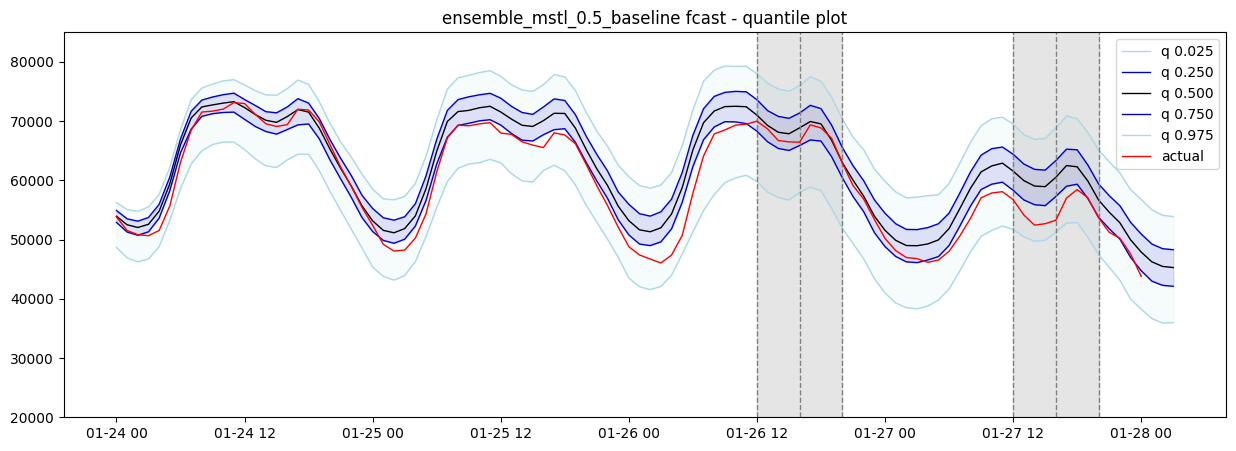

In [79]:
for fold in range(n_fold):

    scores_dict = new_res_dict[f"fold_{fold}"]['scores']

    # make dataframe from dictionary
    df_res = pd.concat(scores_dict.values())
    df_res.index = scores_dict.keys()

    # add col of avg q scores
    df_res['avg_q'] = df_res[['q-score 0.025', 'q-score 0.250', 'q-score 0.500', 'q-score 0.750', 'q-score 0.975']].mean(axis=1)

    # rank by avg q score
    df_res = df_res.sort_values(by='avg_q')
    display(df_res.head(20))

    # get top model and plot
    top_model = df_res.index[0]
    top_model_preds = new_res_dict[f"fold_{fold}"]['preds'][top_model]
    df_test = new_res_dict[f"fold_{fold}"]['df_test']
    subm_timestamps = new_res_dict[f"fold_{fold}"]['subm_timestamps']
    model_train.plot_quantile_fcast(top_model_preds, subm_timestamps, df_test, 
                                    title=f"{top_model} fcast")